# 半正定嵌入演算法(Semidefinite Embedding)

##### 先引入我們需要的packages

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cvxpy as cp
from scipy.io import loadmat  

# MNIST Dataset

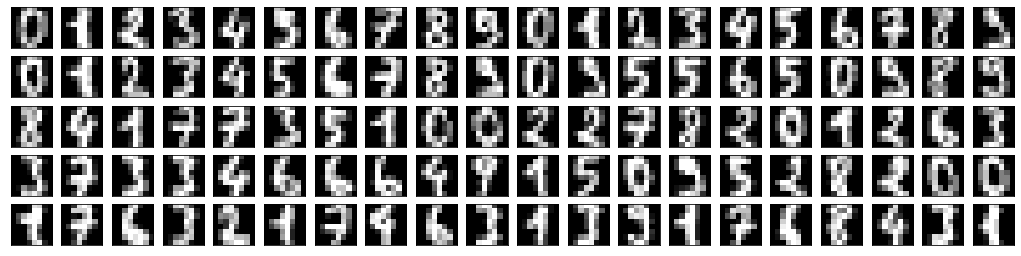

In [7]:
from sklearn.datasets import load_digits
digits = load_digits()
X=(digits.data/16)[:100]
y=digits.target[:100]
plt.rcParams["figure.figsize"] = (18,18)
plt.gray() 
for i in range(100):
    plt.subplot(20, 20, i + 1)
    plt.imshow(digits.images[i], cmap=plt.cm.gray, vmax=16, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.show() 

# Ball Tree

In [8]:
def BuildSubtree(root,points,index,leaf_size,depth):
    if(depth==0):
        return
    centroid=np.mean(points[index,:],axis=0)
    root.centroid=centroid
    root.radius=np.max(np.sum((points[index,:]-centroid)**2,axis=1))**0.5
    farthest_point_1=np.argmax(np.sum((points[index,:]-centroid)**2,axis=1))
    real_index_1=index[farthest_point_1]
    distance_array_1=np.sum((points[index,:]-points[real_index_1,:])**2,axis=1)
    farthest_point_2=np.argmax(np.sum((points[index,:]-points[real_index_1,:])**2,axis=1))
    real_index_2=index[farthest_point_2]
    distance_array_2=np.sum((points[index,:]-points[real_index_2,:])**2,axis=1)
    BOOL=(distance_array_1<=distance_array_2)
    child1_index,child2_index=index[BOOL],index[~BOOL]
    root.index1,root.index2=real_index_1,real_index_2
    if(len(child1_index)<=leaf_size and len(child2_index)<=leaf_size):
        if(depth==1):
            print("tree is not complete")
        root.child1="end"
        root.child2="end"
    elif(len(child1_index)<=leaf_size):
        root.child1="end"
        root.child2=Tree()
        BuildSubtree(root.child2,points,child2_index,leaf_size,depth-1)
    elif(len(child2_index)<=leaf_size):
        root.child2="end"
        root.child1=Tree()
        BuildSubtree(root.child1,points,child1_index,leaf_size,depth-1)
    else:
        root.child1=Tree()
        BuildSubtree(root.child1,points,child1_index,leaf_size,depth-1)
        root.child2=Tree()
        BuildSubtree(root.child2,points,child2_index,leaf_size,depth-1)
    return

# k-Nearest Neighbor Search

In [9]:
def check(X,p,k,Q,index):
    if(np.sum((p-X[index,:])**2)<np.sum((p-X[Q[0],:])**2)):
        Q.append(index)
        Q=np.array(Q)
        Q=list(Q[np.argsort(-1*np.sum((p-X[Q,:])**2,axis=1))])
        if(len(Q)>k):    
            del Q[0]
    return Q

def kNN_search(X,p,k,Q,root):
    if(np.sqrt(np.sum((p-root.centroid)**2))-root.radius>=np.sqrt(np.sum((p-X[Q[0],:])**2))):
        return Q
    elif(root.child1=="end" and root.child2=="end"):
        Q=check(X,p,k,Q,root.index1)
        Q=check(X,p,k,Q,root.index2)
    elif(root.child1=="end"):
        Q=check(X,p,k,Q,root.index1)
        Q=kNN_search(X,p,k,Q,root.child2)
    elif(root.child2=="end"):
        Q=check(X,p,k,Q,root.index2)
        Q=kNN_search(X,p,k,Q,root.child1)
    else:
        Q=kNN_search(X,p,k,Q,root.child1)
        Q=kNN_search(X,p,k,Q,root.child2)
    return Q    

In [10]:
class Tree:
    def __init__(self):
        self.child1=None
        self.child2=None
        self.radius=None
        self.centroid=None
        self.index1=None
        self.index2=None
root=Tree()
N,M=X.shape
Index=np.array(range(0,N))
BuildSubtree(root,X,Index,1,30)
n_neighbors=10
neighbors=np.zeros((N,n_neighbors))
for i in tqdm(range(N)):
    Q=[]
    while(len(Q)!=n_neighbors+1):
        Q=list(np.random.randint(N,size=1))
        Q=kNN_search(X,X[i,:],n_neighbors+1,Q,root)
    del Q[n_neighbors]
    neighbors[i]=Q

# SDE

In [11]:
P = cp.Constant(np.dot(X,X.T))
Q = cp.Variable((N,N), PSD=True)
Q.value = np.zeros((N,N))
ONES = cp.Constant(np.ones((N, 1)))
T = cp.Constant(N)
objective = cp.Maximize(cp.multiply((1 / T),cp.trace(Q))-cp.multiply((1 / (T * T)),cp.trace(cp.matmul(cp.matmul(Q, ONES), ONES.T))))
constraints = [Q >> 0, cp.sum(Q, axis=1) == 0]
neighbors=neighbors.astype(int)
for i in tqdm(range(N)):
    for j in  neighbors[i]:
        constraints.append((P[i, i] + P[j, j] - P[i, j] - P[j, i]) -
                           (Q[i, i] + Q[j, j] - Q[i, j] - Q[j, i]) == 0)
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.CVXOPT,eps=1e-2,max_iters=2500,warm_start=False)

10.416963755517614

# LDL Decomposition

In [12]:
from scipy.linalg import ldl
l, d, perm = ldl(Q.value)
X_sub=np.dot(l[:,:2],np.diag(np.diagonal(d)[:2]))

# Plot

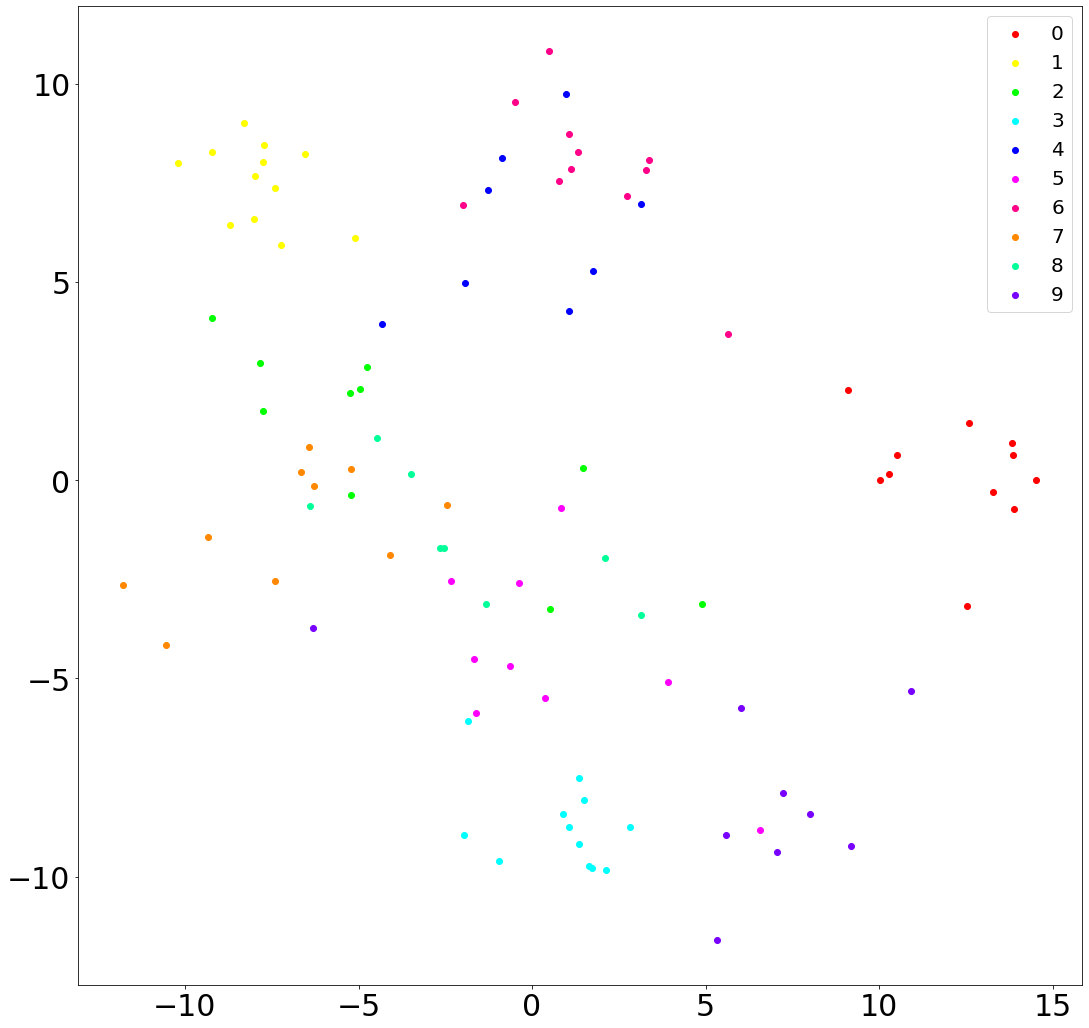

In [13]:
color=["#FF0000","#FFFF00","#00FF00","#00FFFF","#0000FF",
       "#FF00FF","#FF0088","#FF8800","#00FF99","#7700FF"]
plt.rcParams["figure.figsize"] = (18,18)
for i in range(0,10):
    BOOL=(y==i)
    plt.scatter(X_sub[BOOL,0],X_sub[BOOL,1],c=color[i],label=i)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=20)
plt.show()